# 2 PyTorch 基础

## 2.6 使用 Numpy 实现机器学习

In [ ]:
# 1) 导入需要的库
import numpy as np
# %matplotlib inline
from matplotlib import pyplot as plt

# 2) 生成输入数据 x 及目标数据 y
# 设置随机数种子，生成同一份数据，以便用多种方法进行比较
np.random.seed(100)
x = np.linspace(-1, 1, 100).reshape(100, 1)
y = 3*np.power(x, 2) +2 + 0.2*np.random.rand(x.size).reshape(100,1)

# 3) 查看 x,y 数据分布情况
# 画图
# plt.scatter(x, y)
# plt.show()

# 4) 初始化权重参数
# 随机初始化参数
w1 = np.random.rand(1, 1)
b1 = np.random.rand(1, 1)

# 5) 训练模型
lr = 0.001

for i in range(800):
    y_pred = np.power(x,2) * w1 + b1

    loss = 0.5 * (y_pred - y) ** 2
    loss = loss.sum()

    grad_w = np.sum((y_pred - y) * np.power(x, 2))
    grad_b = np.sum((y_pred - y))

    w1 -= grad_w * lr
    b1 -= grad_b * lr

    # print(loss)
print(w1,b1)
plt.plot(x, y_pred, 'r-', label='predict')
plt.scatter(x, y, color='blue', marker='o', label='true')
plt.xlim(-1, 1)
plt.ylim(2, 6)
plt.legend()
plt.show()





## 2.7 使用 Tensor 及 Autograd 实现机器学习

In [ ]:
# 1) 导入需要的库
import torch as t
# %matplotlib inline
from matplotlib import pyplot as plt

# 2) 生成输入数据 x 及目标数据 y
t.manual_seed(100)
dtype = t.float
# 生成 x 坐标数据，x 为 tensor，需要把 x 的形状转换为 100x1
x = t.unsqueeze(t.linspace(-1, 1, 100), dim=1)
# 生成 y 坐标数据，y 为 tensor，形状为 100x1，另加上一些噪声
y = 3 * x.pow(2) + 2 + 0.2 * t.rand(x.size(),requires_grad=True).view(100, 1)

# 画图，把 tensor 数据转换为 numpy 数据
plt.scatter(x.detach().numpy(), y.detach().numpy())
plt.show()

# 3) 初始化权重参数
# 随机初始化参数，参数 w、b 为需要学习的，故需 requires_grad=True
w = t.randn(1, 1, dtype = dtype, requires_grad=True)
b = t.zeros(1, 1, dtype = dtype, requires_grad=True)

# 4) 训练模型
lr = 0.001

for ii in range(80):
    y_pred = x.pow(2).mm(w) + b
    loss = 0.5 * (y_pred - y) ** 2
    loss = loss.sum()

    # 自动计算梯度，梯度存放在 grad 属性中
    loss.backward(retain_graph=True)
    # loss.backward()

    # 手动更新参数，需要用 torch.no_grad()，使上下文环境中切断自动求导的计算
    with t.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad

    # 梯度清零
        w1.grad.zero_()
        b1.grad.zero_()
# 5) 可视化训练结果
plt.plot(x.detach().numpy(), y_pred.detach().numpy(), 'r-', label='preddice') # Predict
plt.scatter(x.detach().numpy(), y.detach().numpy(), color='blue', marker='o', label='true') # True data
plt.xlim(-1, 1)
plt.ylim(2, 6)
plt.legend()
plt.show()

print(w, b)

# 3 PyTorch 神经网络工具箱

### 3.2.2 准备数据

In [ ]:
# 1. 导入必要的模块
import numpy as np
import torch
# 导入 PyTorch 内置的 mnist 数据
from torchvision.datasets import mnist
# 导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# 导入 nn 及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [ ]:
# 2. 定义一些超参数
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.5

In [ ]:
# 3. 下载数据并对数据进行预处理 
# 定义预处理函数，这些预处理一次放在 Compose 函数中
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# 下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=False)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)

# dataloader 是一个可迭代对象，可以使用迭代器一样使用
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

### 3.2.3 可视化源数据

In [ ]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
# plt.show()

### 3.2.4 构建模型

In [ ]:
# 1) 构建网络
class Net(nn.Module):
    '''
    使用 sequential 构建网络，Sequential() 函数的功能是将网络的层组合到一起
    '''
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [ ]:
lr = 0.01
momentum = 0.9

In [ ]:
# 2) 实例化网络
# 检查是否有可用的 GPU，有则使用，否则使用 CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs")
#         # dim = 0[20, xxx] --> [10, ...], [10, ...] on 2GPUs
#         model = nn.DataParallel(model)
# 实例化网络
model = Net(28 * 28, 300, 100, 10)
model.to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

### 3.2.5 训练模型

In [ ]:
# 1. 训练模型
losses = []
acces = []
eval_losses = []
eval_acces = []

writer = SummaryWriter(log_dir='logs4', comment='train-loss')

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    # 动态修改参数学习率
    if epoch%5 == 0:
        optimizer.param_groups[0]['lr'] *= 0.1
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
    
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上验证效果
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc

    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}' 
          .format(epoch, train_loss/len(train_loader), train_acc/len(train_loader), 
                  eval_loss/len(test_loader),eval_acc/len(test_loader)))


In [ ]:
# 2. 可视化训练及测试损失值
plt.title('trainloss')
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train Loss'], loc = 'upper right')

## 3.6 动态修改学习率参数

In [ ]:
for epoch in range(num_epoches):
# 动态修改参数学习率
    if epoch%5 == 0:
        optimizer.param_groups[0]['lr'] *= 0.1
        print(optimizer.param_groups[0]['lr'])

## 3.7 优化器比较


In [ ]:
# 1) 导入需要的模块
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
# 超参数
LR = 0.01
BATCH_SIZE = 32
EPOCH = 12

In [ ]:
# 2) 生成数据
# 生成训练数据
# torch.unsqueeze() 的作用是将一维变为二维，torch 只能处理二维的数据
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)
# 0.1 * torch.normal(x.size()) 增加噪点
y = x.pow(2) + 0.1 * torch.normal(torch.zeros(*x.size()))

torch_dataset = Data.TensorDataset(x,y)
# 得到一个代批量的生成器
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
# 3) 构建神经网络
class Net(torch.nn.Module):
    # 初始化
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)
        self.predict = torch.nn.Linear(20, 1)
    # 前向传递
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

In [ ]:
# 4) 使用多种优化器
net_SGD      = Net()
net_Momentum = Net()
net_RMSProp  = Net()
net_Adam     = Net()

nets = [net_SGD, net_Momentum, net_RMSProp, net_Adam]

opt_SGD         = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum    = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.9)
opt_RMSProp     = torch.optim.RMSprop(net_RMSProp.parameters(), lr=LR, alpha=0.9)
opt_Adam        = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSProp, opt_Adam]

In [ ]:
# 5) 训练模型
loss_func = torch.nn.MSELoss()
loss_his = [[], [], [], []]     # 记录损失
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, opt, l_his in zip(nets, optimizers, loss_his):
            output = net(batch_x) # Get output for every net
            loss = loss_func(output, batch_y) # Compute loss for every net
            opt.zero_grad() # Clear gradients for next train
            loss.backward() # Backpropagation, compute gradients
            opt.step() # Apply gradients
            l_his.append(loss.data.numpy()) # Loss recoder
labels = ['SGD', 'Momentum', 'RMSProp', 'Adam']

In [ ]:
# 6) 可视化结构
for i, l_his in enumerate(loss_his):
    plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 0.2))
plt.show()

# 4 PyTorch数据处理工具箱

## 4.2 utils.data 简介

In [ ]:
# 1) 导入需要的模块
import torch
from torch.utils import data
import numpy as np

In [ ]:
# 2) 定义获取数据集的类
# 该类继承基类 Dataset，自定义一个数据集及对应标签
class TestDataset(data.Dataset): # 继承 Dataset
    def __init__(self):
        self.Data = np.asarray([[1,2], [3,4], [2,1], [3,4], [4,5]]) # 一些由 2 维向量表示的数据集
        self.Label = np.asarray([0, 1, 0, 1, 2]) # 这是数据集对应的标签

    def __getitem__(self, index):
        # 把 numpy 转换为 Tensor
        txt = torch.from_numpy(self.Data[index])
        label = torch.tensor(self.Label[index])
        return txt,label
    
    def __len__(self):
        return len(self.Data)

In [ ]:
if __name__ == "__main__":
    pass
    test_loader = data.DataLoader(Test,batch_size=2,shuffle=False,num_workers=2)
    for i,traindata in enumerate(test_loader):
        print('i:',i)
        Data,Label=traindata
        print('data:',Data)
        print('Label:',Label)

In [ ]:
test_loader = data.DataLoader(Test,batch_size=2,shuffle=False,num_workers=2)
dataiter = iter(test_loader)
imgs, labels = next(dataiter)

## 4.3 torchvision 简介

### 4.3.2 ImageFolder

from torchvision import datasets loader = datasets.ImageFolder(r'D:\Users\Administrator\Desktop\PythonDLbasedonPytorch\data\torchvision_data') loader = data.DataLoader(dataset)

In [ ]:
from torchvision import transforms, utils
from torchvision import datasets
import torch
import matplotlib.pyplot as plt

my_trans = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
train_data = datasets.ImageFolder(r'D:\Users\Administrator\Desktop\PythonDLbasedonPytorch\data\torchvision_data', transform=my_trans)
train_loader = data.DataLoader(train_data, batch_size=8, shuffle=True,)

for i_batch, img in enumerate(train_loader):
    if i_batch == 0:
        print(img[1])
        fig = plt.figure()
        grid = utils.make_grid(img[0])
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.show()
        utils.save_image(grid, 'test01.png')
    break

In [ ]:
# 打开 test01.png 文件
from PIL import Image
Image.open('test01.png')

## 4.4 可视化工具

### 4.4.1 tensorboardX 简介

In [ ]:
from tensorboardX import SummaryWriter
# 实例化 SummaryWriter，并指明日志存放路径。在当前目录没有 logs 目录将自动创建。
writer = SummaryWriter(log_dir='logs')
# 调用实例
writer.add_xxx()
# 关闭 writer
writer.close()


### 4.4.2 用 tensorboardX 可视化神经网络

In [39]:
# 1) 导入需要的模块
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.tensorboard import SummaryWriter
# from tensorboardX import SummaryWriter

ValueError: module functions cannot set METH_CLASS or METH_STATIC

In [ ]:
# 2) 构建神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.bn = nn.BatchNorm2d(20)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x) + F.relu(-x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.bn(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [ ]:
# 3) 把模型保存为 graph
# 定义输入
input = torch.rand(32, 1, 28, 28)
# 实例化神经网络
model = Net()
# 将 model 保存为 graph
with SummaryWriter(log_dir='logs', comment='Net') as w:
    w.add_graph(model, (input, ))
w.close()

### 4.4.3 用 tensorboardX 可视化损失值

In [ ]:
import numpy as np

dtype = torch.FloatTensor
writer = SummaryWriter(log_dir='logs', comment='Linear')
np.random.seed(100)
x_train = np.linspace(-1, 1, 100).reshape(100, 1)
y_train = 3 * np.power(x_train, 2) + 2 + 0.2 * np.random.rand(x_train.size).reshape(100, 1)

model = nn.Linear(input_size, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epoches):
    inputs = torch.from_numpy(x_train).type(dtype)
    targets = torch.from_numpy(y_train).type(dtype)

    output = model(inputs)
    loss = criterion(output, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 保存 loss 的数据与 epoch 数值
    writer.add_scalar('训练损失值', loss, epoch)

### 4.4.4 用 tensorboardX 可视化特征图

In [ ]:
import torchvision.utils as vutils
writer = SummaryWriter(log_dir='logs', comment='feature map')

img_grid = vutils.make_grid(x, normalize=True, scale_each=True, nrow=2)
net.eval()
for name, layer in net._modeles.items():
    # 为 fc 层预处理 x
    x = x.view(x.size(0), -1) if "fc" in name else x
    print(x.size())

    x = layer(x)
    print(f'{name}')

    # 查看卷积层的特征图
    if 'layer' in name or 'conv' in name:
        x1 = x.transpose(0, 1) # C,B,H,W ---> B,C,H,W
        # normalize 进行归一化处理
        img_grid = vutils.make_grid(x1, normalize=True, scale_each=True, nrow=4)
        writer.add_image(f'{name}_feature_maps', img_grid, global_step=0)


# 5 机器学习基础

# 6 视觉处理基础

## 6.1 卷积神经网络简介


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 36, 3, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1296, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 36*6*6)
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return x
net = CNNNet()
# net = net.to(device=device)


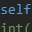

In [34]:
# 导入图片查看维度
from PIL import Image
im = Image.open(r'd:\Users\Administrator\Desktop\test.png')
im

In [ ]:
from tensorboardX import SummaryWriter


# 3) 把模型保存为 graph
# 定义输入
input = torch.rand(32*32, 3)
# 实例化神经网络
# 将 model 保存为 graph
with SummaryWriter(log_dir='logs', comment='Net') as w:
    w.add_graph(net, (input, ))
w.close()

## 6.5 PyTorch 实现 CIFAR-10 多分类

# 7 自然语言处理基础

# 8 生成式深度学习

## 8.1 用变分自编码器生成图像

In [ ]:
# 定义重构损失函数及 KL 散度
reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
# 两者相加得总损失
loss = reconst_loss + kl_div

In [ ]:
# 1) 导入需要的包
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
# 2) 定义一些超参数
image_size       = 784
h_dim            = 400
z_dim            = 20
num_epochs       = 30
batch_size       = 128
learning_rate    = 0.001

In [ ]:
# 3) 对数据集进行预处理
# 下载 MNIST 训练集
dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=False)
# 数据加载
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# 4) 构建 AVE 模型，主要由 Encode 和 Decode 两部分组成
# 定义 AVE 模型
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

# 用 mu，log_var 生成一个潜在空间点 z，mu，log_var 为两个统计参数，我们假设这个建设分布能生成图像
def reparameterize(self, mu, log_var):
    std = torch.exp(log_var/2)
    eps = torch.rand_like(std)
    return mu+eps*std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [ ]:
# 5) 选择 GPU 及优化器
# 设置 PyTorch 在哪块 GPU 上运行，这里假设使用序号为 0 的这块 GPU
torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# 6) 训练模型，同时保存原图像与随机生成的图像
with torch.no_grad():
    # 保存采样图像，及潜在向量 Z 通过解码器生成的新图像
    z = torch.randn(batch_size, z_dim).to(device)
    out = model.decode(z).view(-1, 1, 28, 28)
    save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

    # 保存重构图像，即原图像通过解码器生成的图像
    out, _, _ = model(x)
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

In [ ]:
# 7) 展示原图像及重构图像
reconsPath = './ave_samples/reconst-30.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图像
plt.asix('off') # 不显示坐标轴
plt.show()

In [ ]:
# 8) 显示由潜在空间点 Z 生成的新图像
genPath = './ave_samples/sampled-30.png'
Image = mpimg.imread(genPath)
plt.imshow(Image) # 显示图像
plt.asix('off') # 不显示坐标轴
plt.show()

## 8.2 GAN 简介

In [ ]:
# 定义判断器对真图像的损失函数
outputs = D(images)
d_loss_real = criterion(outputs, real_labels)

In [ ]:
# 定义判别器对假图像（即由潜在空间点生成的图像）的损失函数
z = torch.randn(batch_size, latent_size).to(device)
fake_images = G(z)
outputs = D(fake_images)
d_loss_fake = criterion(outputs, fake_labels)
fake_score = outputs
# 得到判别器总的损失函数
d_loss = d_loss_real + d_loss_fake

In [ ]:
z = torch.randn(batch_size, latent_size).to(device)
fake_images = G(z)
outputs = D(fake_images)

g_loss = criterion(outputs, real_labels)

## 8.3 用 GAN 生成图像

### 8.3.1 判别器

In [ ]:
# 构建判断器
D = nn.Sequential(
    nn.Linear(image_size, hidden_size), 
    nn.LeakyReLU(0.2), 
    nn.Linear(hidden_size, hidden_size), 
    nn.LeakyReLU(0.2), 
    nn.Linear(hidden_size, 1), 
    nn.Sigmoid())

### 8.3.2 生成器

In [ ]:
# 构建生成器
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size), 
    nn.ReLU(), 
    nn.Linear(hidden_size, hidden_size), 
    nn.ReLU(), 
    nn.Linear(hidden_size, image_size), 
    nn.tanh())

### 8.3.3 训练模型

In [ ]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # 定义图像是真或假的标签
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ----------------------------------------------
        #                训练判别器
        # ----------------------------------------------
        
        # 定义判别器对真图像的损失函数
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # 定义判别器对假图像（即由潜在空间点生成的图像）的损失函数
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # 对生成器、判别器的梯度清零
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # ------------------------------------------------
        #                训练生成器
        # ------------------------------------------------

        # 定义生成器对假图像的损失函数，这里我们要求判别器生成的图像越来越像真图片
        # 故损失函数中的标签改为真图像的标签，即希望生成的假图像，越来越靠近真图像
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        g_loss = criterion(outputs, real_labels)
        
        # 对生成器、判别器的梯度清零，进行反向传播及运行生成器的优化器
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
        # 保存真图像
        if (epoch+1) == 1:
            images = images.reshape(images.size(0), 1, 28, 28)
            save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
        # 保存假图像
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
            save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    
    # 保存模型
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

### 8.3.4 可视化结果

In [ ]:
reconsPath = './gan_samples/fake_images-200.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()